In [10]:
import numpy as np
import pylab as plt
from scipy import fftpack
import pandas as pd
import seaborn as sns
cm = sns.color_palette()

In [11]:
import xml.etree.ElementTree as ET
import h5py

def get_lsl_info_from_xml(xml_str_or_file):
    try:
        root = ET.fromstring(xml_str_or_file)
    except FileNotFoundError:
        root = ET.fromstring(xml_str_or_file)
    info = {}
    channels = [k.find('label').text for k in root.find('desc').find('channels').findall('channel')]
    fs = int(root.find('nominal_srate').text)
    return channels, fs


def get_info(f, drop_channels):
    labels, fs = get_lsl_info_from_xml(f['stream_info.xml'][0])
    print('fs: {}\nall labels {}: {}'.format(fs, len(labels), labels))
    channels = [label for label in labels if label not in drop_channels]
    print('selected channels {}: {}'.format(len(channels), channels))
    n_protocols = len([k for k in f.keys() if ('protocol' in k and k != 'protocol0')])
    protocol_names = [f['protocol{}'.format(j+1)].attrs['name'] for j in range(n_protocols)]
    print('protocol_names:', protocol_names)
    return fs, channels, protocol_names


def load_data(file_path):
    with h5py.File(file_path) as f:
        fs, channels, p_names = get_info(f, ['A1', 'A2', 'AUX'])
        data = [f['protocol{}/raw_data'.format(k + 1)][:] for k in range(len(p_names))]
        df = pd.DataFrame(np.concatenate(data), columns=channels)
        df['block_name'] = np.concatenate([[p]*len(d) for p, d in zip(p_names, data)])
        df['block_number'] = np.concatenate([[j + 1]*len(d) for j, d in enumerate(data)])

    return df, fs, p_names, channels

def load_signals_data(file_path):
    with h5py.File(file_path) as f:
        fs, channels, p_names = get_info(f, ['A1', 'A2', 'AUX'])
        data = [f['protocol{}/signals_data'.format(k + 1)][:] for k in range(len(p_names))]
        df = pd.DataFrame(np.concatenate(data), columns=['P4', 'Signal', 'P42', 'Signal2', 'Composite', 'Composite2'])
        df['block_name'] = np.concatenate([[p]*len(d) for p, d in zip(p_names, data)])
        df['block_number'] = np.concatenate([[j + 1]*len(d) for j, d in enumerate(data)])
    return df

In [39]:
data_path = "/Users/basilminkov/Neuroscience/Data/Test/20.02.17/Alpha1_02-20_17-52-50/experiment_data.h5"
df_full, fs, p_names, channels = load_data(data_path)

fs: 500
all labels 32: ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'Ft9', 'Fc5', 'Fc1', 'Fc2', 'Fc6', 'Ft10', 'T3', 'C3', 'Cz', 'C4', 'T4', 'Tp9', 'Cp5', 'Cp1', 'Cp2', 'Cp6', 'Tp10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2']
selected channels 32: ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'Ft9', 'Fc5', 'Fc1', 'Fc2', 'Fc6', 'Ft10', 'T3', 'C3', 'Cz', 'C4', 'T4', 'Tp9', 'Cp5', 'Cp1', 'Cp2', 'Cp6', 'Tp10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2']
protocol_names: ['Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Rest', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Rest', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Rest', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock']


In [12]:
df = load_signals_data("/Users/basilminkov/Neuroscience/Data/Test/20.02.17/Alpha1_02-20_17-52-50/experiment_data.h5")

fs: 500
all labels 32: ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'Ft9', 'Fc5', 'Fc1', 'Fc2', 'Fc6', 'Ft10', 'T3', 'C3', 'Cz', 'C4', 'T4', 'Tp9', 'Cp5', 'Cp1', 'Cp2', 'Cp6', 'Tp10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2']
selected channels 32: ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'Ft9', 'Fc5', 'Fc1', 'Fc2', 'Fc6', 'Ft10', 'T3', 'C3', 'Cz', 'C4', 'T4', 'Tp9', 'Cp5', 'Cp1', 'Cp2', 'Cp6', 'Tp10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2']
protocol_names: ['Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Rest', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Rest', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Rest', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock']


In [40]:
x_r = df.loc[df['block_name']=='Real', 'P4'].as_matrix()
y_r = df.loc[df['block_name']=='Real', 'Composite'].as_matrix()
df_r = df_full.loc[df_full['block_name']=='Real']

x_m = df.loc[df['block_name']=='Mock', 'P4'].as_matrix()
y_m = df.loc[df['block_name']=='Mock', 'Composite'].as_matrix()
df_m = df_full.loc[df_full['block_name']=='Mock']

In [41]:
#plt.plot(y)
#plt.plot(x)
fs = 500
events = np.where(np.diff((x_r>y_r)*1) > 0)[0]
trials_r = []
c = 0
for ev in events:
    if ev - c > 3*fs:
        trials_r.append(df_r[ev-500:ev+1000])
        c = ev
    
events = np.where(np.diff((x_m>y_m)*1) > 0)[0]
trials_m = []
c = 0
for ev in events:
    if ev - c > 3*fs:
        trials_m.append(df_m[ev-500:ev+1000])
        c = ev

ValueError: cannot copy sequence with size 1500 to array axis with dimension 34

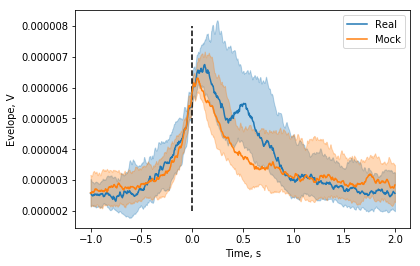

In [27]:
t = np.arange(trials_r.shape[1])/fs - 500/fs

plt.plot(t, np.percentile(trials_r, 50, 0), c=cm[0])
plt.fill_between(t, np.percentile(trials_r, 25, 0), 
                 np.percentile(trials_r, 75, 0), color=cm[0], alpha=0.3)

plt.plot(t, np.percentile(trials_m, 50, 0), c=cm[1])
plt.fill_between(t, np.percentile(trials_m, 25, 0), 
                 np.percentile(trials_m, 75, 0), color=cm[1], alpha=0.3)

plt.vlines([0], [0.000002], [0.000008], linestyle='--')
plt.legend(['Real', 'Mock'])
plt.xlabel('Time, s')
plt.ylabel('Evelope, V')
plt.show()

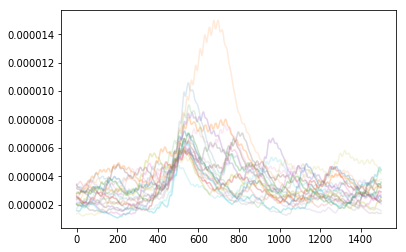

In [24]:
plt.plot(trials_r[:10].T, alpha=0.15)
plt.show()
#plt.plot(trials_m.T, 'b', alpha=0.07)
None

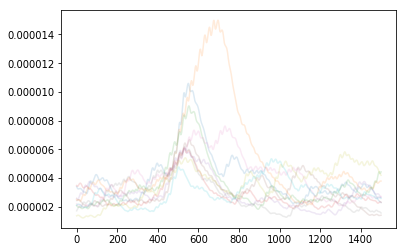

In [25]:
plt.plot(trials_m[:10].T, alpha=0.15)
plt.show()
None

In [125]:
trials_m.shape

(64, 1500)

In [126]:
trials_r.shape

(67, 1500)

In [47]:
a = []
a.append(df_m[ev-500:ev+1000])

In [48]:
a.append(df_m[ev-500:ev+1000])